# UNet Model Comparison for Single Malignancy

In [1]:
# if something goes wrong with the variables - run this and clear everything
%reset -f

In [2]:
import tensorflow as tf

print("Number of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

strategy = tf.distribute.MirroredStrategy()

Number of GPUs Available:  1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [3]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import json
import time

import sys
sys.path.append('../../utils')
sys.path.append('../../models')

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
loss_functions = ['combined_jaccard_dice_loss', 'jaccard_loss', 'dice_loss', 'focal_loss', 'binary']
loss_name = loss_functions[0] 

# resnet_tl_resunet
# model_names = ['simple_unet', 'simple_resunet', 'vgg_tl_unet', 'vgg_tl_resunet', 'attention_unet', 'attention_resunet']
model_names =['vgg_tl_unet', 'vgg_tl_resunet']
# model_name = model_names[0]

num_models = len(model_names) # number of models

In [5]:
df = pd.read_csv('../../data/raw/data_filtered.csv')
df = df[df['status'] == 'abnormal']
print(len(df))
df.head()

497


,patient_id,image_id,view,status,m_mass,b_mass,mic_cluster,mac,z_index,breast_density,notes,Unnamed: 11
10,3,0003-RCC,RCC,abnormal,0.0,1.0,0.0,0.0,NaN,Scattered Fibroglandular Densities,NaN,NaN
11,3,0003-RMLO,RMLO,abnormal,0.0,1.0,0.0,0.0,NaN,Scattered Fibroglandular Densities,NaN,NaN
16,5,0005-LCC,LCC,abnormal,0.0,1.0,0.0,0.0,NaN,Scattered Fibroglandular Densities,NaN,NaN
17,5,0005-LMLO,LMLO,abnormal,0.0,1.0,0.0,0.0,NaN,Scattered Fibroglandular Densities,NaN,NaN
22,12,0012-LCC,LCC,abnormal,0.0,1.0,0.0,1.0,NaN,Scattered Fibroglandular Densities,NaN,NaN


**Select Appropriate Class for Training**

In [6]:
# select the required class
classes = ['malignant_mass', 'benign_mass', 'macrocalcifications', 'microcalcifications', 'masses']
selected_class = classes[0]

if selected_class=='malignant_mass':
    df = df[df['m_mass'] == 1.0]
    mask_gray_value = 76
    class_name = '_mmass.png'
elif selected_class=='benign_mass':
    df = df[df['b_mass'] == 1.0]
    mask_gray_value = 149
    class_name = '_bmass.png'
elif selected_class=='macrocalcifications':
    df = df[df['macro'] == 1.0]
    mask_gray_value = 178
    class_name = '_macro.png'
elif selected_class=='microcalcifications':
    df = df[df['micro'] == 1.0]
    mask_gray_value = 255
    class_name = '_micro.png'
elif selected_class == 'masses':
    df = df[(df['m_mass'] == 1.0) | (df['b_mass'] == 1.0)]
    mask_gray_value = 255
    class_name = '_masses.png'
else:
    print('Invalid class name')

In [7]:
print(len(df))
df.head()

268


,patient_id,image_id,view,status,m_mass,b_mass,mic_cluster,mac,z_index,breast_density,notes,Unnamed: 11
38,16,0016-LCC,LCC,abnormal,1.0,1.0,0.0,0.0,NaN,Heterogeneously Dense,NaN,NaN
39,16,0016-LMLO,LMLO,abnormal,1.0,0.0,0.0,0.0,NaN,Heterogeneously Dense,NaN,NaN
42,18,0018-LCC,LCC,abnormal,1.0,0.0,0.0,0.0,NaN,Heterogeneously Dense,NaN,NaN
43,18,0018-LMLO,LMLO,abnormal,1.0,0.0,0.0,0.0,NaN,Heterogeneously Dense,NaN,NaN
46,19,0019-RCC,RCC,abnormal,1.0,0.0,0.0,0.0,NaN,Heterogeneously Dense,NaN,NaN


In [8]:
np.random.seed(42)
tf.random.set_seed(42)

# if crop is used
IMAGE_HEIGHT = 2048//4
IMAGE_WIDTH = 1024//4

# IMAGE_HEIGHT = 3200//4
# IMAGE_WIDTH = 1728//4

image_size = (IMAGE_HEIGHT, IMAGE_WIDTH)

image_dir = '../../data/raw/abnormal/images/'
mask_dir = '../../data/raw/abnormal/masks/'

image_files = sorted([image_dir + id + '.png' for id in df['image_id']])
# mask_files = sorted([mask_dir + id + '.png' for id in df['image_id']])

mask_files = []

for image_id in df['image_id']:
    folder_path = os.path.join(mask_dir, image_id)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith(class_name):
                mask_files.append(os.path.join(folder_path, file))
                
print(len(mask_files), len(image_files))

268 268


In [9]:
logs_directory = f'../../logs/annotation_class_pixels/all_models_test/{selected_class}/{loss_name}/'
os.makedirs(logs_directory, exist_ok=True)

results_dir = f'../../results/annotation_class_pixels/all_models_test/{selected_class}/{loss_name}/'
os.makedirs(results_dir, exist_ok=True)

**Pre-processing**

In [10]:
from preprocessing import crop_breast, dilate, truncate, clahe

def preprocessing_pipeline(img, mask):
    image, mask, new_height, new_width = crop_breast(img.numpy().squeeze(), mask.numpy().squeeze())
    # image = truncate(image, lower_percentile=20, upper_percentile=100)
    # image = dilate(image, kernel_size=3, iterations=1)
    image = clahe(image, clip=1.0, gridSize=20)
    
    image = image.reshape(new_height, new_width, 1)
    mask = mask.reshape(new_height, new_width, 1)
    
    img_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    mask_tensor = tf.convert_to_tensor(mask, dtype=tf.float32)
    
    return img_tensor, mask_tensor


def wrap_preprocessing(image, mask):
    processed_image, processed_mask = tf.py_function(
        preprocessing_pipeline,
        [image, mask],
        [tf.float32, tf.float32]
    )
    
    processed_image.set_shape([None, None, 1])
    processed_mask.set_shape([None, None, 1])
    
    return processed_image, processed_mask

**Data Augmentation**

In [11]:
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation_shared = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    # preprocessing.RandomRotation(0.1, fill_mode='constant', interpolation='nearest'),
    # preprocessing.RandomZoom(0.1, 0.1, fill_mode='constant', interpolation='nearest'),
])

data_augmentation_image_only = tf.keras.Sequential([
    preprocessing.RandomContrast(0.2),
    # Add more
])

def add_augmentation(img, mask):
    combined = tf.concat([img, mask], axis=-1)  # Stack the image and mask
    combined = data_augmentation_shared(combined)
    img, mask = tf.split(combined, [img.shape[-1], mask.shape[-1]], axis=-1)  # Split them back
    
    # Apply image-only augmentations
    img = data_augmentation_image_only(img)
    
    return img, mask

**Data Preparation**

In [12]:
def process_path_grayscale(image_path, mask_path):
    
    # Process Image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=1)

    # Process Mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    
    # Custom Preprocessing
    img, mask = wrap_preprocessing(img, mask)
    
    # Resize
    img = tf.image.resize(img, image_size)
    mask = tf.image.resize(mask, image_size, method='nearest')
    
    # Data augmentation
    # img, mask = add_augmentation(img, mask)
    
    # Normalize
    img = img / 255  # Normalize [0, 1]
    mask = mask / mask_gray_value # Normalize [0, 1]
    
    mask = tf.cast(mask, tf.int32)

    return img, mask

In [13]:
def process_path_rgb(image_path, mask_path):
    img, mask = process_path_grayscale(image_path, mask_path)
    img_rgb = tf.image.grayscale_to_rgb(img)
    return img_rgb, mask

**Test and Train Split**

In [14]:
image_files_unseen = image_files[-1]
mask_files_unseen = mask_files[-1]

image_files = image_files[:-1]
mask_files = mask_files[:-1]

In [15]:
train_images, test_images, train_masks, test_masks = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

In [16]:
print(f"Number of training images: {len(train_images)}")
print(f"Number of training masks: {len(train_masks)}")
print(f"Number of testing images: {len(test_images)}")
print(f"Number of testing masks: {len(test_masks)}")

Number of training images: 213
Number of training masks: 213
Number of testing images: 54
Number of testing masks: 54


**Build Tensorflow Data Pipeline**

In [17]:
def get_dataset_for_model(model_name):
    if model_name in ['vgg_tl_unet', 'vgg_tl_resunet']:
        process_function = process_path_rgb
        cache_file_train = 'cached_train_data_rgb.tfrecord'
        cache_file_test = 'cached_test_data_rgb.tfrecord'
    else:
        process_function = process_path_grayscale
        cache_file_train = 'cached_train_data_grayscale.tfrecord'
        cache_file_test = 'cached_test_data_grayscale.tfrecord'
    
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
    
    batch_size = 8
    prefetch_buffer_size=tf.data.AUTOTUNE
    
    train_dataset = train_dataset.map(process_function).batch(batch_size).prefetch(prefetch_buffer_size).cache(filename=cache_file_train)
    test_dataset = test_dataset.map(process_function).batch(batch_size).prefetch(prefetch_buffer_size).cache(filename=cache_file_test)
    
    return train_dataset, test_dataset

In [18]:
# # Sanity check

# for images, masks in train_dataset.take(1):
#     print("Image batch shape:", images.shape)
#     print("Image batch dtype:", images.dtype)
#     print("Mask batch shape:", masks.shape)
#     print("Mask batch dtype:", masks.dtype)

# gc.collect()    

In [19]:
# # do sanity check - view image and mask randomly

# def show_img_mask(dataset, batch, image_number):
#     for images, masks in train_dataset.take(batch):
        
#         image = images[image_number]
#         mask = masks[image_number]

#         plt.figure(figsize=(10, 5))

#         plt.subplot(1, 2, 1)
#         plt.imshow(tf.squeeze(image), cmap='gray')
#         plt.title('Image')
#         plt.axis('off')

#         plt.subplot(1, 2, 2)
#         plt.imshow(tf.squeeze(mask), cmap='gray')
#         plt.title('Mask')
#         plt.axis('off')

#         plt.show()

#         print("Unique values in the mask:", np.unique(tf.squeeze(mask).numpy()))

# show_img_mask(dataset=train_dataset, batch=3, image_number=2)

### **Define the UNet Models**

In [20]:
from unet_models import unet_model, res_unet_model, VGG16_UNet, VGG16_Res_UNet, attention_unet_model, attention_res_unet_model
# ResNet50_Res_UNet

In [21]:
def get_model(model_name):
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1)
    num_filters=64
    
    if model_name == 'simple_unet':
        return unet_model(num_classes=1, input_size=input_shape, num_filters=num_filters, dropout=0.1, batch_norm=True)
    elif model_name == 'simple_resunet':
        return res_unet_model(num_classes=1, input_size=input_shape, num_filters=num_filters, dropout=0.1, batch_norm=False)
    elif model_name == 'vgg_tl_unet': # VGG requires 3 channels
        return VGG16_UNet(num_classes=1, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), dropout=0.0, batch_norm=True)
    elif model_name == 'vgg_tl_resunet': # ResNet requires 3 channels
        return VGG16_Res_UNet(num_classes=1, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), dropout=0.0, batch_norm=True)
    # elif model_name == 'resnet_tl_resunet': # ResNet requires 3 channels
        # return ResNet50_Res_UNet(num_classes=1, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), dropout=0.0, batch_norm=True)
    elif model_name == 'attention_unet':
        return attention_unet_model(num_classes=1, input_size=input_shape, num_filters=num_filters, dropout=0.1, batch_norm=True)
    elif model_name == 'attention_resunet':
        return attention_res_unet_model(num_classes=1, input_size=input_shape, num_filters=num_filters, dropout=0.1, batch_norm=True)
    else:
        raise ValueError("Unknown model name")

**Compile Model**

In [22]:
from loss_and_metrics import jaccard_coef, jaccard_loss, dice_coef, dice_loss, combined_jaccard_dice_loss, focal_loss, specificity, precision, recall, f1score

compiled_models = {}

with strategy.scope():
    for model_name in model_names:
        train_dataset, test_dataset = get_dataset_for_model(model_name)
        
        model = get_model(model_name=model_name)
        
        metrics = ['accuracy' ,f1score, specificity, jaccard_coef, dice_coef]
        if loss_name == 'combined_jaccard_dice_loss':
            loss_function = combined_jaccard_dice_loss(alpha=0.5)
        elif loss_name == 'jaccard_loss':
            loss_function = jaccard_loss
        elif loss_name == 'dice_loss':
            loss_function = dice_loss
        elif loss_name == 'focal_loss':
            loss_function = focal_loss
        elif loss_name == 'binary':
            loss_function = 'binary_crossentropy'
        else:
            raise ValueError('Invalid loss function')

        model.compile(optimizer=Adam(lr=1e-5), loss=loss_function, metrics=metrics)

#         model.summary()
        
        compiled_models[model_name] = model
        
        del model

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

**Train Model**

In [23]:
model_histories = {}

for model_name, model in compiled_models.items():
    checkpoint_path = logs_directory + '{}_best.hdf5'.format(model_name)
    model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                       monitor='val_loss',
                                       verbose=1,
                                       save_best_only=True,
                                       save_weights_only=False,
                                       mode='min')
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=7,
                                   verbose=1,
                                   mode='min')
    epochs = 150

    history = model.fit(train_dataset,
                        epochs=epochs,
                        validation_data=test_dataset,
                        verbose=1,
                        shuffle=False,
                        callbacks=[model_checkpoint, early_stopping])
    
    model_histories[model_name] = history
    model.save(logs_directory + '{}.hdf5'.format(model_name))
    del model, history
    gc.collect()

Epoch 1/150
27/27 [==============================] - 228s 7s/step - loss: 12.5223 - accuracy: 0.4643 - f1score: 0.0275 - specificity: 0.5156 - jaccard_coef: 0.0140 - dice_coef: 0.0275 - val_loss: 12.3197 - val_accuracy: 0.9356 - val_f1score: 0.0340 - val_specificity: 0.6819 - val_jaccard_coef: 0.0173 - val_dice_coef: 0.0340

Epoch 00001: val_loss improved from inf to 12.31966, saving model to ../../logs/annotation_class_pixels/all_models_test/malignant_mass/combined_jaccard_dice_loss\vgg_tl_unet_best.hdf5
Epoch 2/150
27/27 [==============================] - 72s 3s/step - loss: 12.2512 - accuracy: 0.6198 - f1score: 0.0382 - specificity: 0.5343 - jaccard_coef: 0.0195 - dice_coef: 0.0382 - val_loss: 12.0540 - val_accuracy: 0.6309 - val_f1score: 0.0394 - val_specificity: 0.5276 - val_jaccard_coef: 0.0201 - val_dice_coef: 0.0394

Epoch 00002: val_loss improved from 12.31966 to 12.05400, saving model to ../../logs/annotation_class_pixels/all_models_test/malignant_mass/combined_jaccard_dice_l

KeyboardInterrupt: 

**Evaluations**

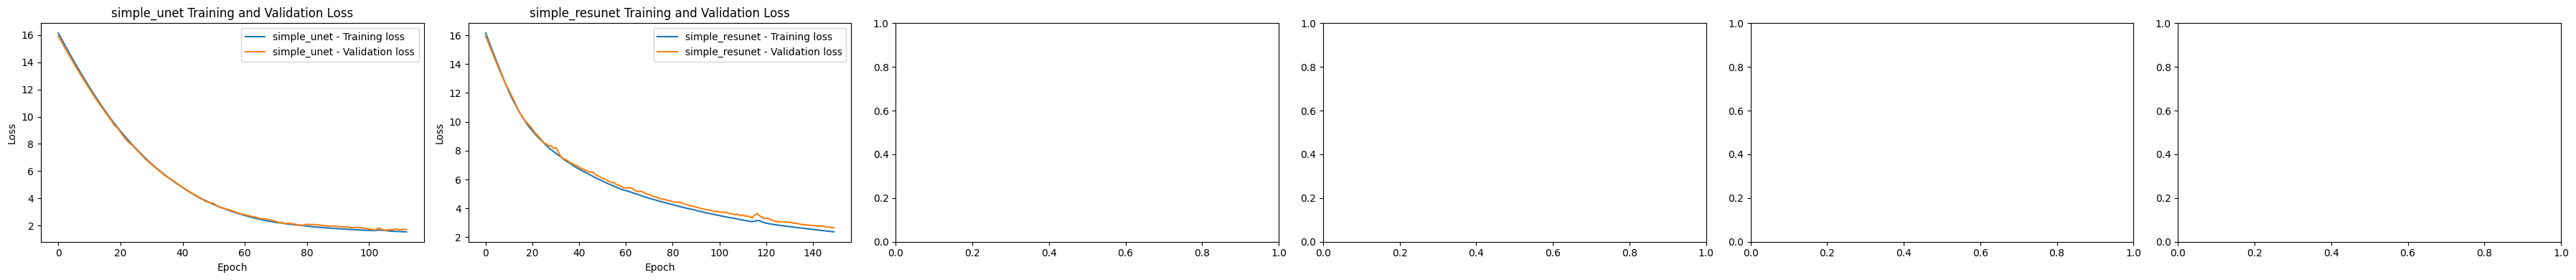

<Figure size 640x480 with 0 Axes>

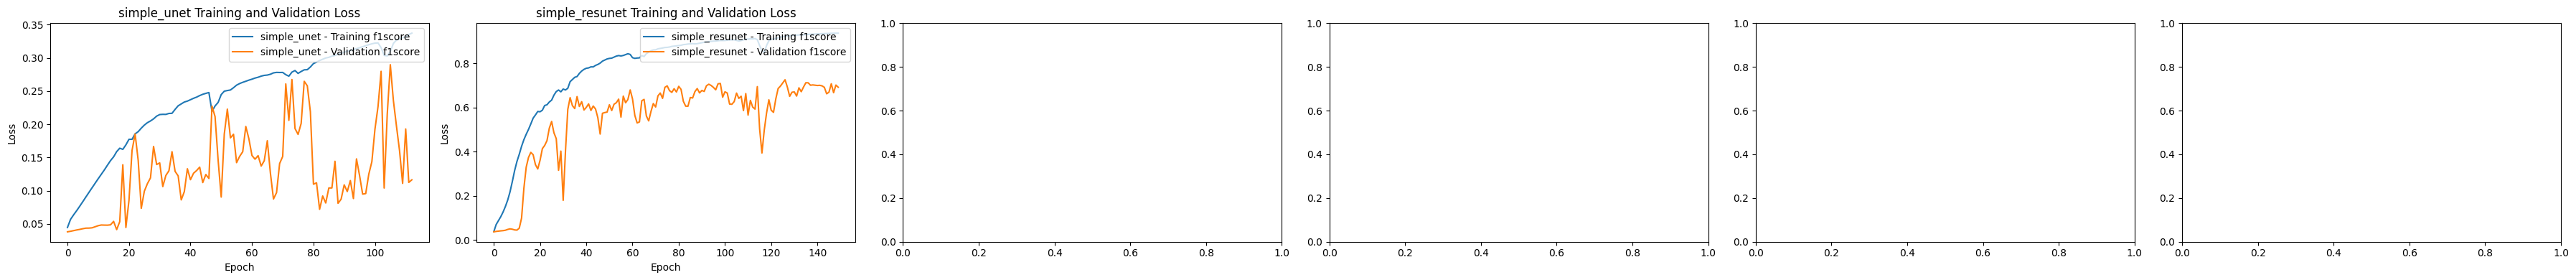

<Figure size 640x480 with 0 Axes>

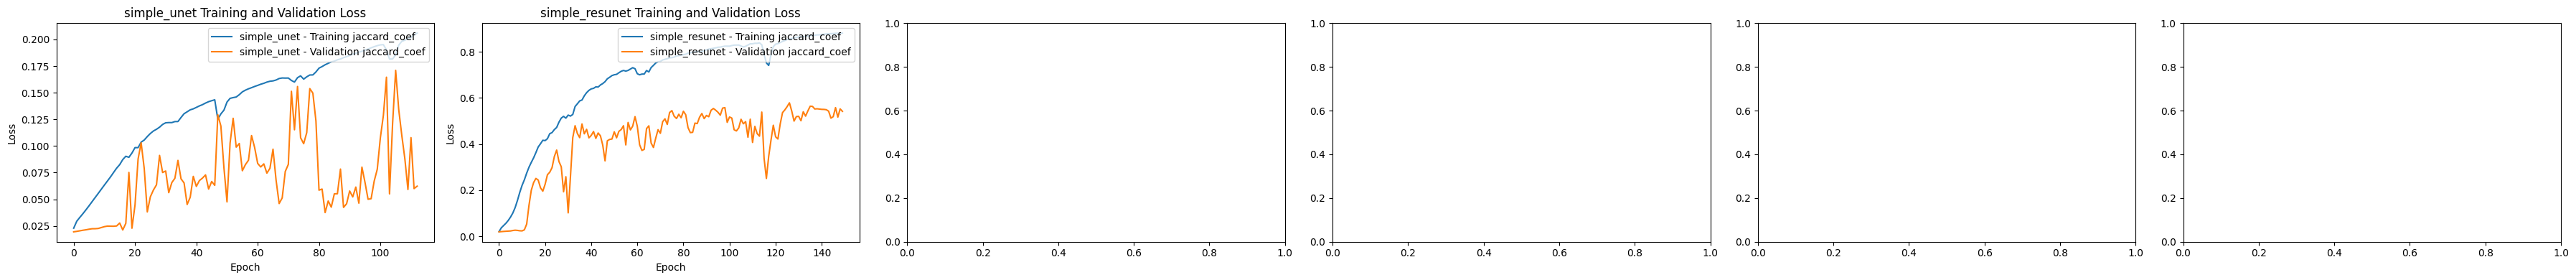

<Figure size 640x480 with 0 Axes>

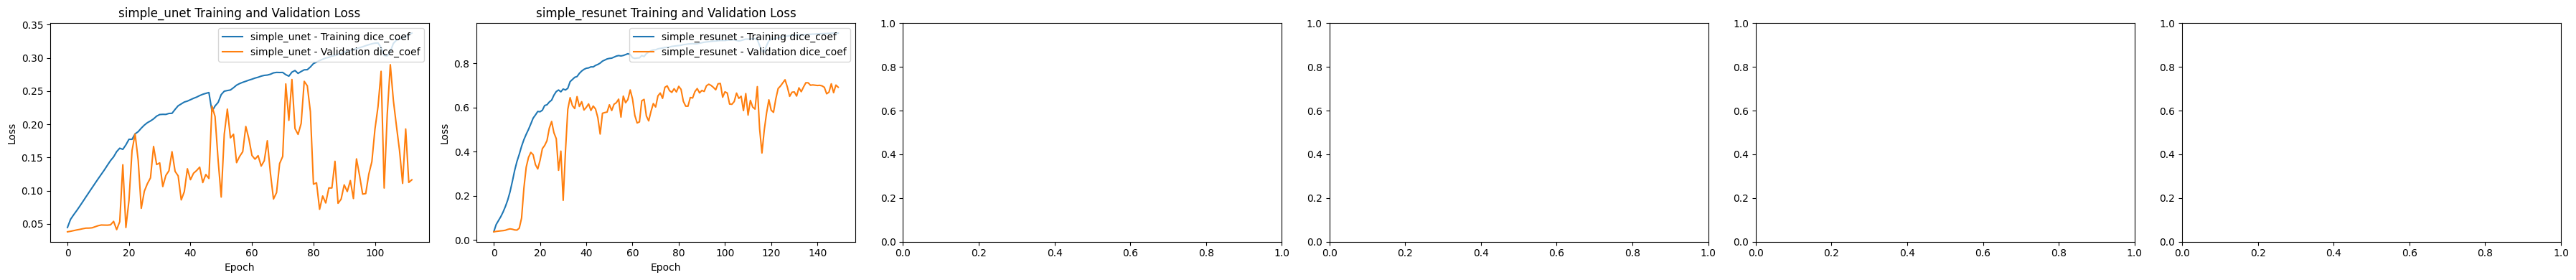

<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_metric(model_name, history, metric, ax):
    ax.plot(history.history[metric], label=f'{model_name} - Training {metric}')
    ax.plot(history.history['val_' + metric], label=f'{model_name} - Validation {metric}')
    
    ax.set_title(f'{model_name} Training and Validation Loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')

def plot_metric_curves(metric):
    fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 4))

    for ax, (model_name, history) in zip(axes, model_histories.items()):
        plot_metric(model_name, history, metric, ax)

    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f'{metric}_curves.png'))
    plt.show()
    plt.clf()
    
plot_metric_curves('loss')

plot_metric_curves('f1score')

plot_metric_curves('jaccard_coef')

plot_metric_curves('dice_coef')

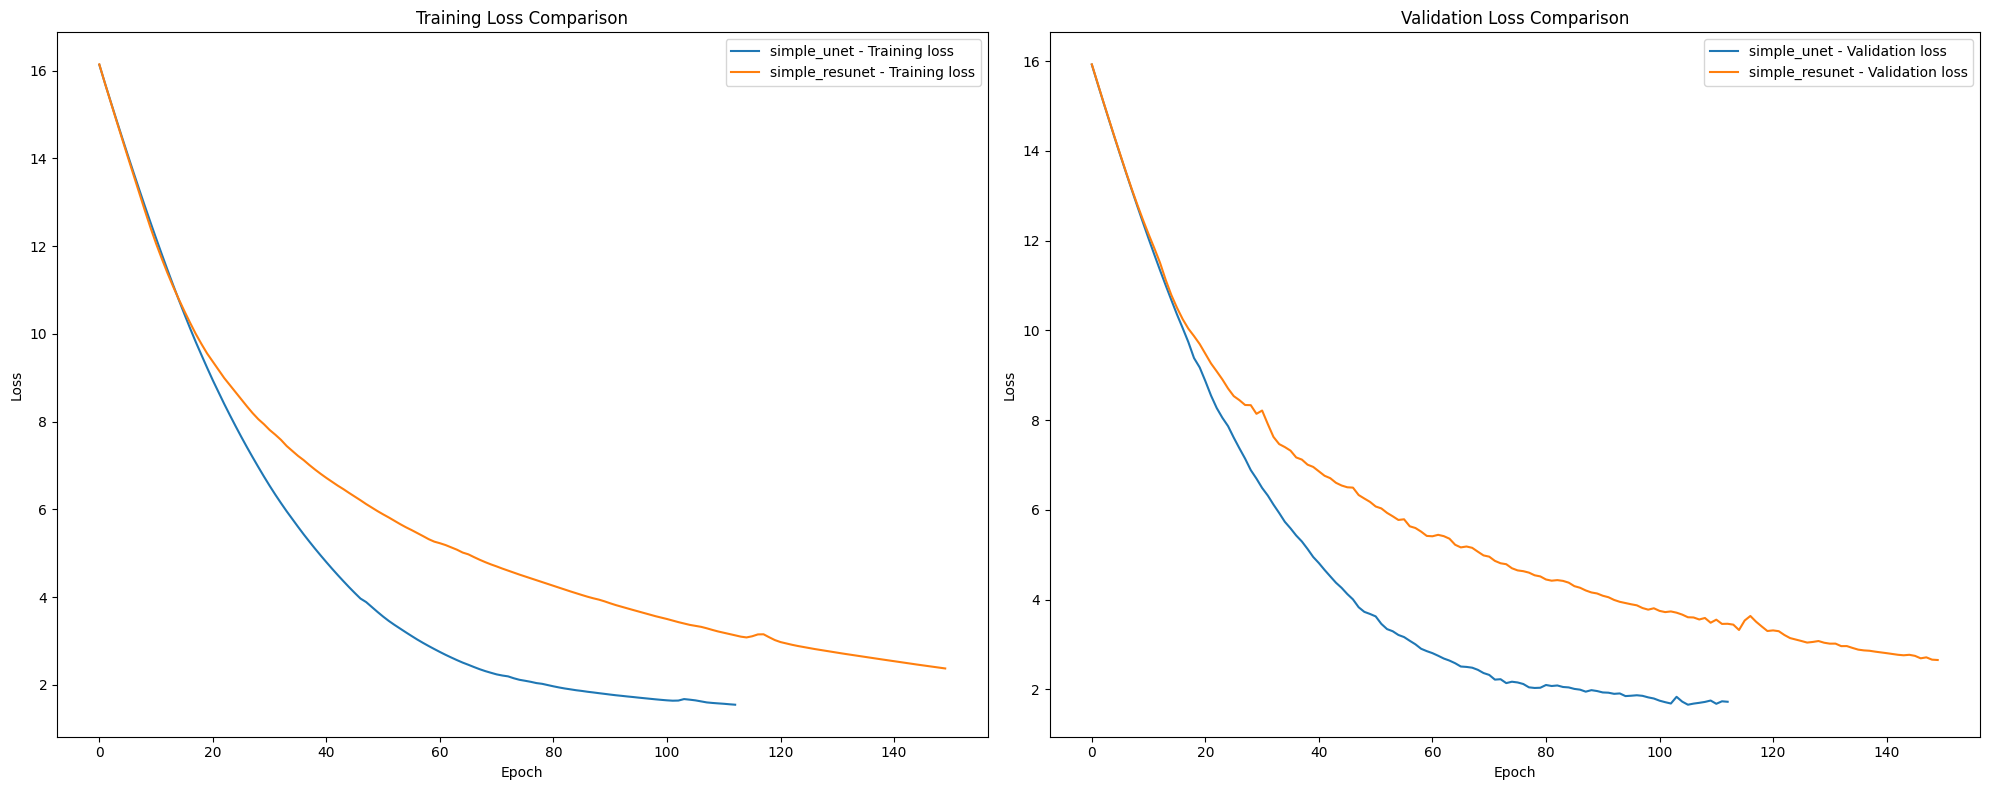

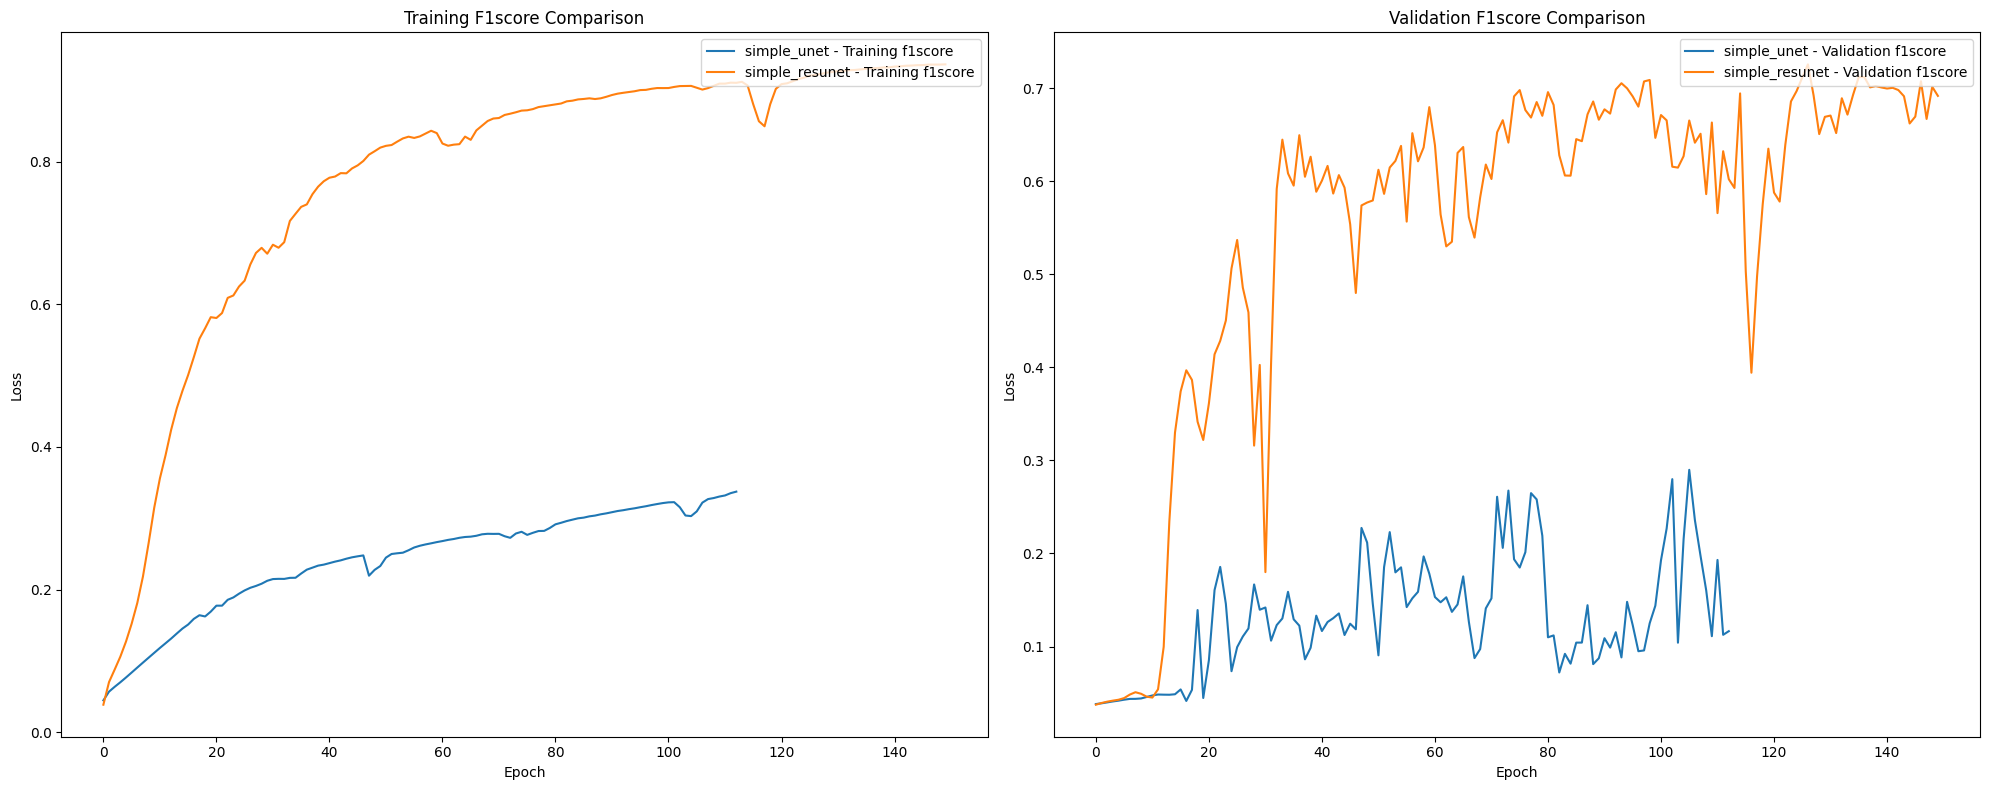

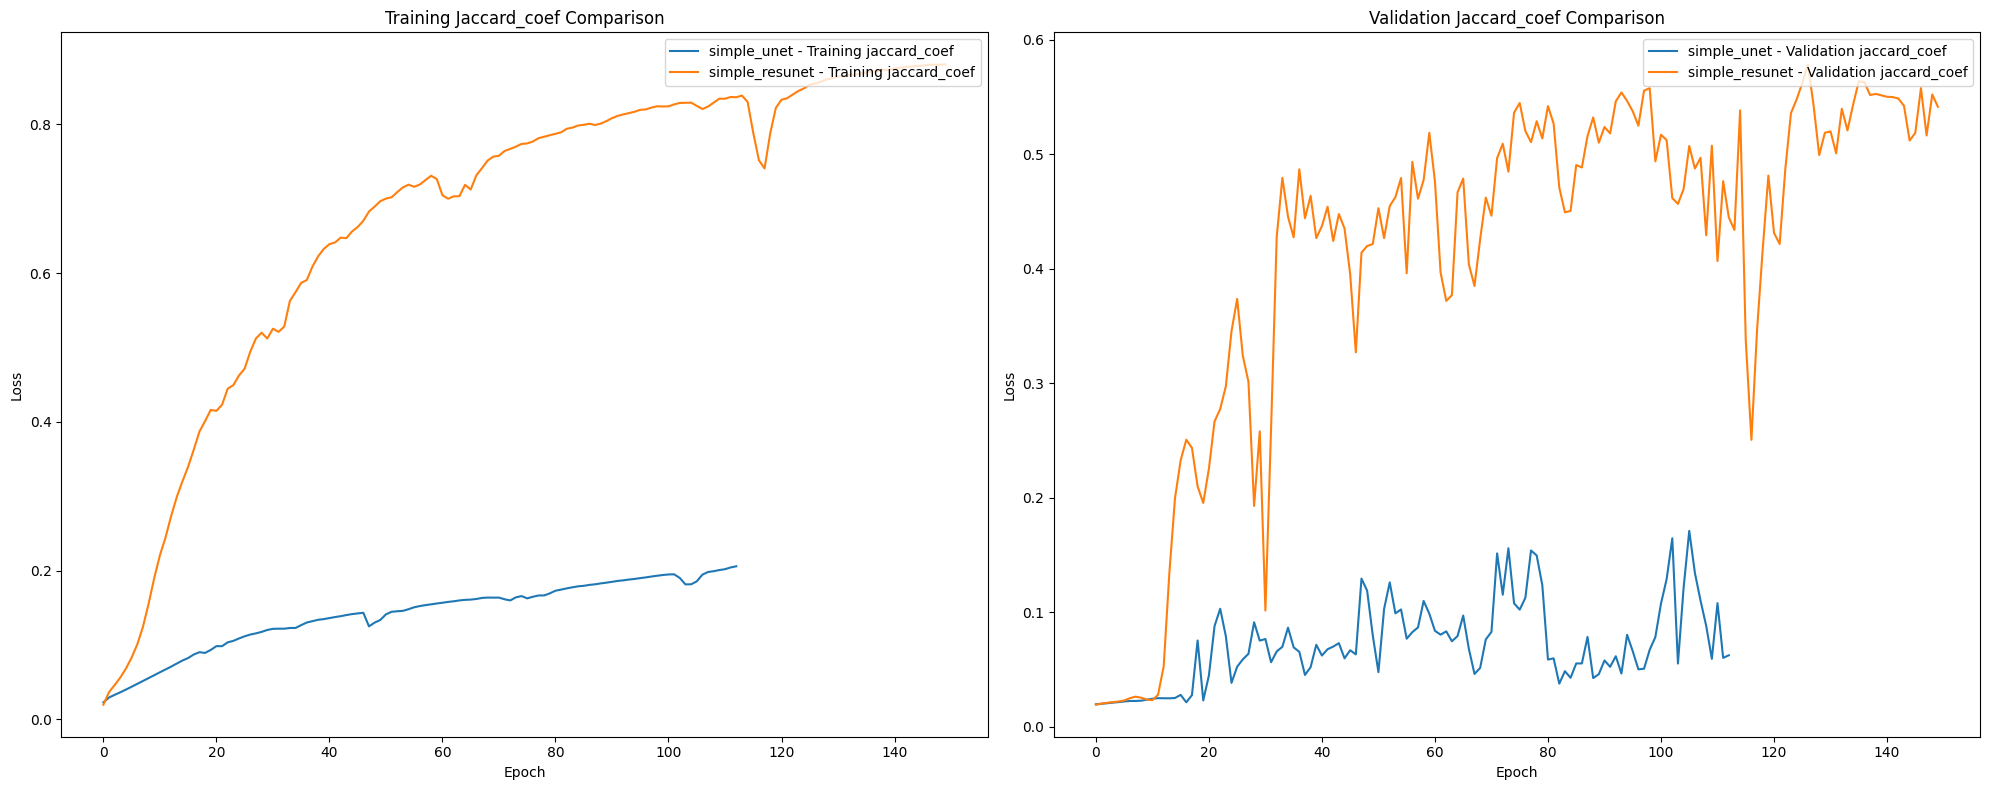

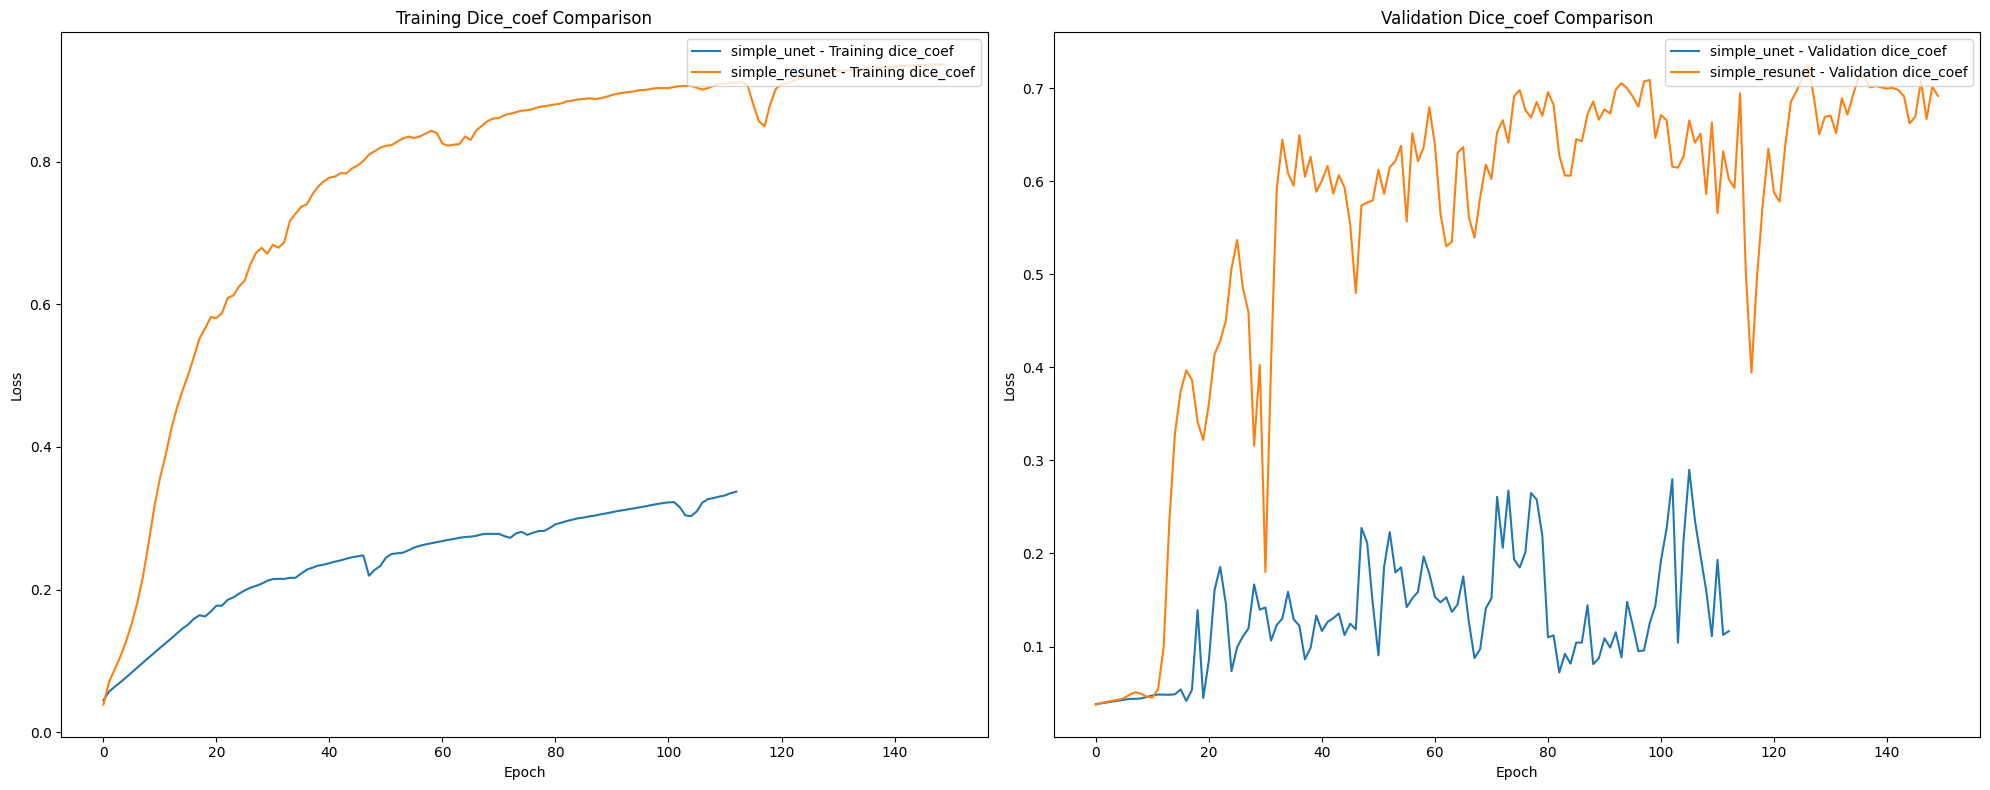

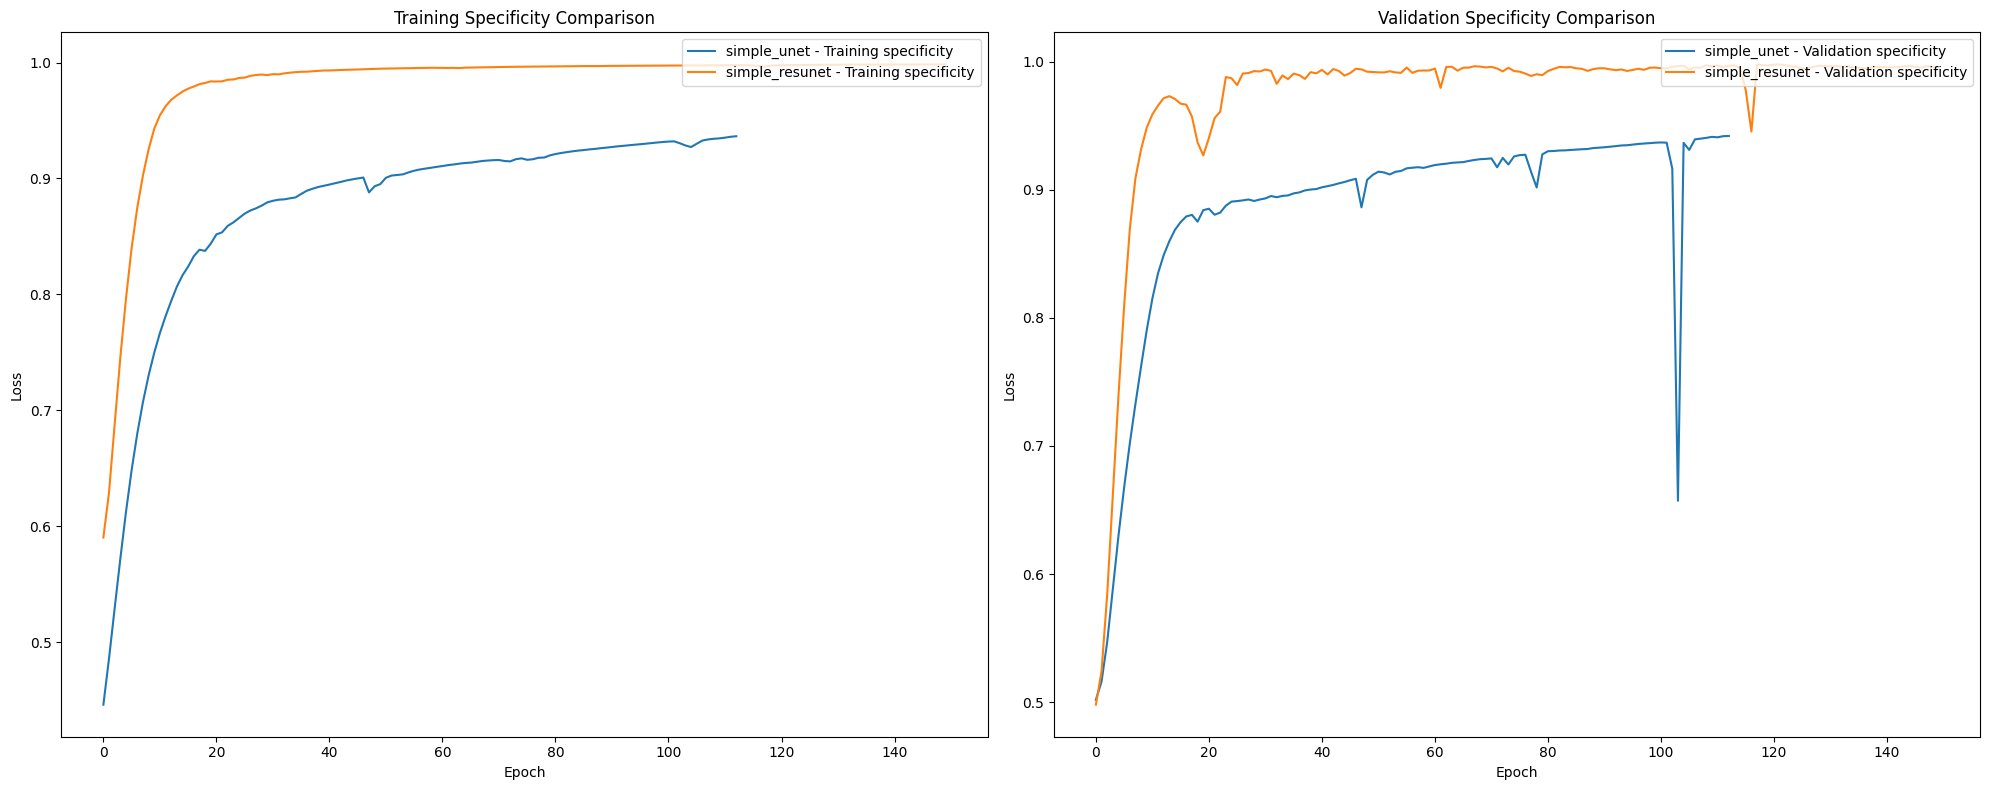

In [ ]:
def metric_comparison(metric):
    plt.figure(figsize=(20, 8))

    for i, (model_name, history) in enumerate(model_histories.items(), start=1):
        plt.subplot(1, 2, 1)
        plt.plot(history.history[metric], label=f'{model_name} - Training {metric}')
        plt.title(f'Training {metric.capitalize()} Comparison')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['val_' + metric], label=f'{model_name} - Validation {metric}')
        plt.title(f'Validation {metric.capitalize()} Comparison')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')

    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f'{metric}_curves_comparison.png'))
    plt.show()
    

metric_comparison('loss')

metric_comparison('f1score')

metric_comparison('jaccard_coef')

metric_comparison('dice_coef')

metric_comparison('specificity')

In [ ]:
from loss_and_metrics import jaccard_coef, jaccard_loss, dice_coef, dice_loss, combined_jaccard_dice_loss, focal_loss, specificity, precision, recall, f1score

threshold = 0.7

models = []

for model_name in model_names[]:
    model_path = logs_directory + '{}_best.hdf5'.format(model_name)
    model = load_model(model_path, compile=False)
    metrics = ['accuracy', f1score, specificity, jaccard_coef, dice_coef]
    if loss_name == 'combined_jaccard_dice_loss':
        loss_function = combined_jaccard_dice_loss(alpha=0.5)
    elif loss_name == 'jaccard_loss':
        loss_function = jaccard_loss
    elif loss_name == 'dice_loss':
        loss_function = dice_loss
    elif loss_name == 'focal_loss':
        loss_function = focal_loss
    elif loss_name == 'binary':
        loss_function = 'binary_crossentropy'
    else:
        raise ValueError('Invalid loss function')
        
    model.compile(optimizer=Adam(lr=1e-5), loss=loss_function, metrics=metrics)
    models.append(model)

In [ ]:
filename = os.path.join(results_dir, 'evaluation_results.txt')

for model, model_name in zip(models, model_names):   
    acc, loss_value, f1, spec, iou, dice = model.evaluate(test_dataset)
    
    # Format the results
    content = f"""
        --------------------
        Model: {model_name}
        --------------------
        Accuracy: {acc:.4f}
        Loss: {loss_value:.4f}
        F1-Score: {f1:.4f}
        Specificity: {spec:.4f}
        IoU / Jaccard Coeff: {iou:.4f}
        Dice Coeff: {dice:.4f}
        """
    print(content)

    with open(filename, 'a') as file:
        file.write('\n' + content)     

7/7 [==============================] - 1s 79ms/step - loss: 1.6611 - f1score: 0.2899 - specificity: 0.9312 - jaccard_coef: 0.1710 - dice_coef: 0.2899

        --------------------
        Model: simple_unet
        --------------------
        Loss: 1.6611
        F1-Score: 0.2899
        Specificity: 0.9312
        IoU / Jaccard Coeff: 0.1710
        Dice Coeff: 0.2899
        
7/7 [==============================] - 1s 86ms/step - loss: 2.6570 - f1score: 0.6916 - specificity: 0.9956 - jaccard_coef: 0.5415 - dice_coef: 0.6916

        --------------------
        Model: simple_resunet
        --------------------
        Loss: 2.6570
        F1-Score: 0.6916
        Specificity: 0.9956
        IoU / Jaccard Coeff: 0.5415
        Dice Coeff: 0.6916
        


Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix_for_model(model, model_name, test_dataset, threshold, ax):
    all_true_labels = []
    all_predicted_labels = []

    for images, masks in test_dataset:
        y_pred = model.predict(images)
        y_pred = tf.cast(y_pred > threshold, tf.float32)
        y_true = tf.cast(masks, tf.float32)

        all_predicted_labels.extend(y_pred.numpy().flatten())
        all_true_labels.extend(y_true.numpy().flatten())

    cm = confusion_matrix(all_true_labels, all_predicted_labels)
        
    class_names = ['Background', 'Lesion']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_title('Confusion Matrix for ' + model_name)
    ax.set_ylabel('Actual Class')
    ax.set_xlabel('Predicted Class')

1/1 [==============================] - 0s 17ms/step


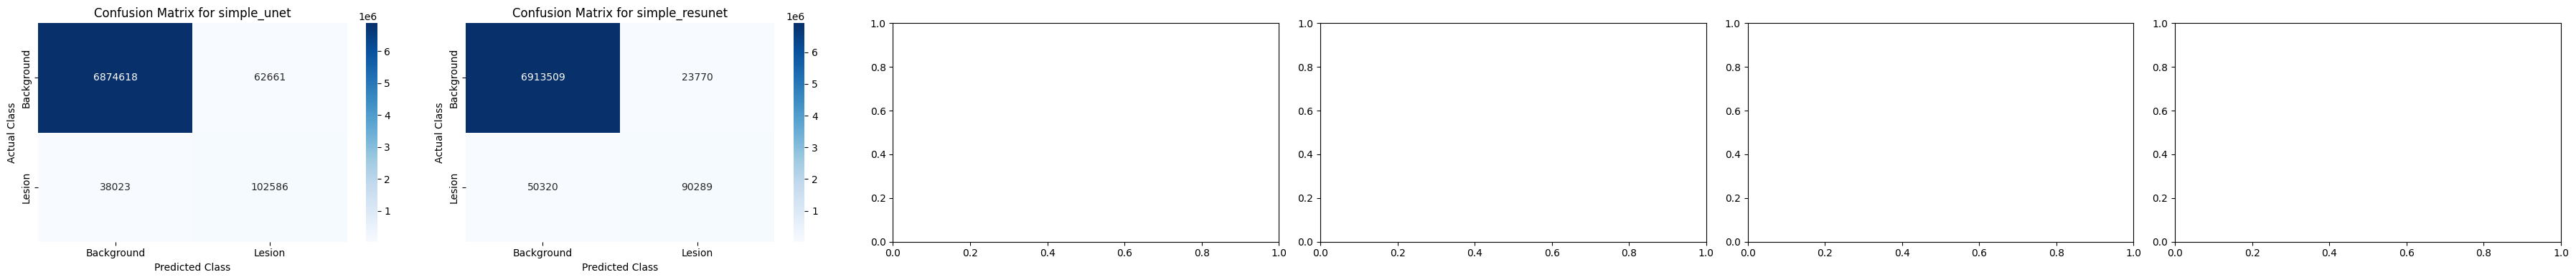

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 4))
        
for ax, model, model_name in zip(axes, models, model_names):
    plot_confusion_matrix_for_model(model, model_name, test_dataset, threshold, ax)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'confusion_matrix.png'))
plt.show()
plt.clf()

iou

In [ ]:
def calculate_batch_iou(true_mask, pred_mask):
    ious = []
    
#     pred_mask = tf.math.round(pred_mask)  # convert pred probs to binary preds (0 or 1)
    pred_mask = tf.cast(pred_mask > threshold, tf.float32)
    true_mask = tf.cast(true_mask, tf.float32)

    intersection = tf.math.logical_and(tf.cast(true_mask, tf.bool), tf.cast(pred_mask, tf.bool))
    union = tf.math.logical_or(tf.cast(true_mask, tf.bool), tf.cast(pred_mask, tf.bool))
    iou = tf.reduce_sum(tf.cast(intersection, tf.float32)) / tf.reduce_sum(tf.cast(union, tf.float32))
    ious.append(iou)

    return tf.stack(ious)

In [ ]:
for model, model_name in zip(models, model_names):
    total_iou = 0.0
    total_batches = 0
    for images, masks in test_dataset:
        preds = model.predict(images)
        batch_iou = calculate_batch_iou(masks, preds)
        total_iou += batch_iou
        total_batches += 1

    mean_iou = total_iou / total_batches
    mean_iou_content = f"Mean IoU for {model_name} = {mean_iou.numpy()}"

    print(mean_iou_content)
    with open(filename, 'a') as file:
        file.write('\n' + mean_iou_content)

print(f"Mean IoU has been added to: {filename}")

1/1 [==============================] - 0s 19ms/step
Mean IoU for simple_unet = [0.5149769]
1/1 [==============================] - 0s 19ms/step
Mean IoU for simple_resunet = [0.562397]
Mean IoU has been added to: ../../results/annotation_class_pixels/all_models/malignant_mass/combined_jaccard_dice_loss/evaluation_results.txt


**Predictions**

Prediction on test image

1/1 [==============================] - 0s 19ms/step


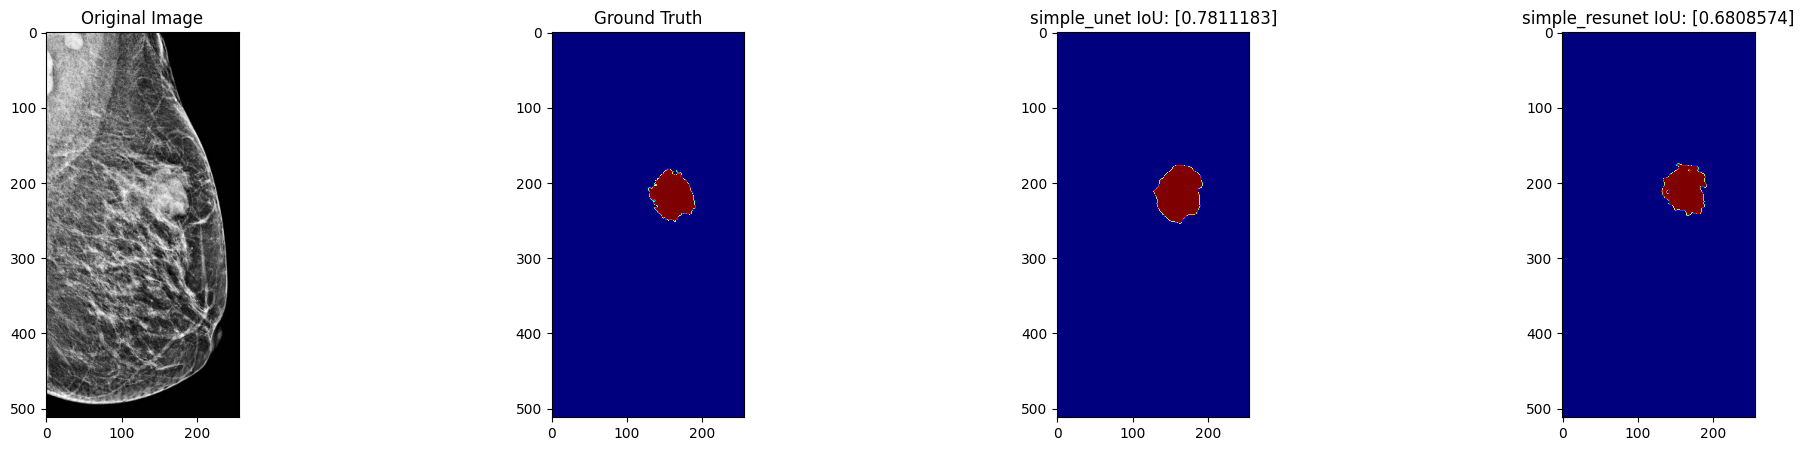

<Figure size 640x480 with 0 Axes>

In [ ]:
def check_predictions_for_all_models(dataset, batch, img, models, model_names, threshold, results_dir):
    for images, masks in dataset.take(batch):
        plt.figure(figsize=(15 + 5 * len(models), 5))
        
        # plot original image
        plt.subplot(1, len(models) + 2, 1)
        plt.imshow(images[img], cmap='grey')
        plt.title("Original Image")
        
        # plot ground truth mask
        plt.subplot(1, len(models) + 2, 2)
        true_masks = tf.cast(masks, tf.float32)
        plt.imshow(true_masks[img], cmap='jet')
        plt.title("Ground Truth")
        
        # loop through each model and plot predictions
        for i, (model, model_name) in enumerate(zip(models, model_names), start=3):
            predicted_masks = model.predict(images)
            predicted_masks = tf.cast(predicted_masks > threshold, tf.float32)
            
            iou = calculate_batch_iou(true_masks[img], predicted_masks[img])
            
            plt.subplot(1, len(models) + 2, i)
            plt.imshow(predicted_masks[img], cmap='jet')
            plt.title(f"{model_name} IoU: {iou}")
        
        plt.savefig(os.path.join(results_dir, 'predictions_comparison_test.png'))
        plt.show()
        plt.clf()


check_predictions_for_all_models(dataset=test_dataset, batch=1, img=3, models=models, model_names=model_names, threshold=threshold, results_dir=results_dir)

Prediction on unseen image

1/1 [==============================] - 0s 17ms/step


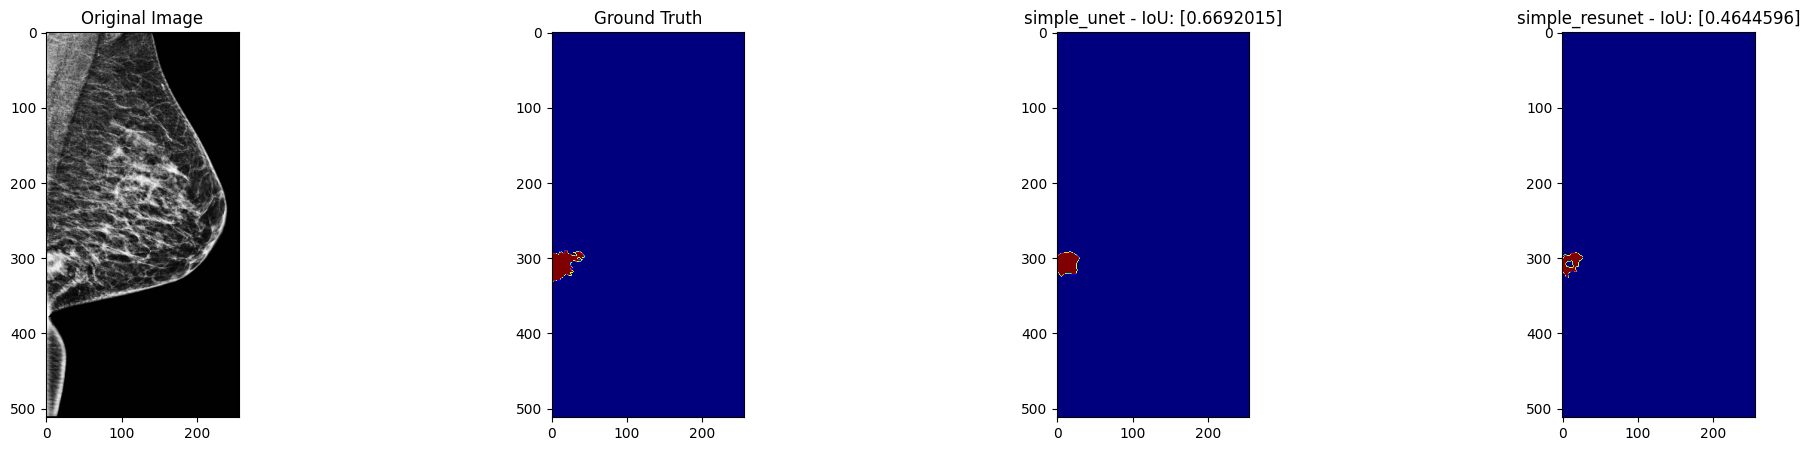

<Figure size 640x480 with 0 Axes>

In [ ]:
def predict_single_image_masks(models, model_names, image_path, mask_path, image_size, mask_gray_value, threshold, results_dir):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=1)
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    image, mask = wrap_preprocessing(image, mask)  
    image = tf.image.resize(image, image_size)
    image = image / 255
    mask = tf.image.resize(mask, image_size, method='nearest')
    mask = tf.math.round(mask / mask_gray_value)
    
    plt.figure(figsize=(15 + 5 * len(models), 5))
    plt.subplot(1, len(models) + 2, 1)
    plt.imshow(image, cmap='gray') # Assuming image is grayscale
    plt.title("Original Image")

    plt.subplot(1, len(models) + 2, 2)
    plt.imshow(mask, cmap='jet') # Assuming mask is single-channel
    plt.title("Ground Truth")

    for i, (model, model_name) in enumerate(zip(models, model_names), start=3):
        if model_name in ['vgg_tl_unet', 'vgg_tl_resunet']:
            image = tf.image.grayscale_to_rgb(image)
        image_processed = tf.expand_dims(image, axis=0)
        mask_processed = tf.expand_dims(mask, axis=0)
        predicted_mask = model.predict(image_processed)
        predicted_mask = tf.cast(predicted_mask > threshold, tf.float32)
        iou = calculate_batch_iou(mask_processed, predicted_mask)

        plt.subplot(1, len(models) + 2, i)
        plt.imshow(predicted_mask[0, :, :, 0], cmap='jet')
        plt.title(f"{model_name} - IoU: {iou}")
    
    plt.savefig(os.path.join(results_dir, 'predictions_comparison_unseen.png'))
    plt.show()
    plt.clf()
    

predict_single_image_masks(models, model_names, image_files_unseen, mask_files_unseen, image_size, mask_gray_value, threshold, results_dir)